# 12주차 실습(2): 분산분석과 사후 검정(post-hoc test)

***

In [2]:
# 아래의 라이브러리를 사용하므로 미리 임포트해 두기 바랍니다.
import numpy as np
import numpy.random as random
import scipy as sp
import scipy.stats as stats
import pandas as pd
from pandas import Series, DataFrame

import statsmodels.formula.api as smf
import statsmodels.api as sm

# 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic')  # 한글폰트 설정 "맑은 고딕"
import seaborn as sns
%matplotlib inline

# 소수점 3자리까지 표시
%precision 3

data = pd.read_csv('health2018.csv')
data

,ID,sex,age,height,weight,waist,BMI,Blood_glucose
0,A901020501,M,80,162.4,56.0,82.2,21.233226,103
1,A901021301,M,78,167.7,76.4,98.3,27.166096,127
2,A901021302,F,75,157.7,53.2,80.7,21.391845,134
3,A901022601,F,43,151.0,53.5,79.7,23.463883,99
4,A901023303,F,80,146.1,57.6,93.0,26.984977,111
...,...,...,...,...,...,...,...,...
5963,R904028502,F,35,159.8,55.6,70.1,21.773149,90
5964,R904028503,F,66,156.9,63.9,87.3,25.957028,93
5965,R904028902,F,73,145.2,51.8,77.2,24.569512,99
5966,R904029201,M,43,176.8,84.1,99.2,26.904906,108


### 구간화(pd.cut)를 이용해 다음 체중 분류를 obesity 열로 추가.
BMI 18.5 미만 : "저체중"

BMI 18.5 이상 25 미만 : "정상"

BMI 25 이상 : "비만"

In [3]:
BMI_cut = [0, 18.5, 25, 100]
BMI_names = ['저체중', '정상', '비만']
data['obesity'] = pd.cut(data.BMI, BMI_cut, labels = BMI_names)
data.head()

,ID,sex,age,height,weight,waist,BMI,Blood_glucose,obesity
0,A901020501,M,80,162.4,56.0,82.2,21.233226,103,정상
1,A901021301,M,78,167.7,76.4,98.3,27.166096,127,비만
2,A901021302,F,75,157.7,53.2,80.7,21.391845,134,정상
3,A901022601,F,43,151.0,53.5,79.7,23.463883,99,정상
4,A901023303,F,80,146.1,57.6,93.0,26.984977,111,비만


### 구간화(pd.cut)를 이용해 연령 분류를 age_group 열로 추가.
20세 이상 30세 미만: '20대' ...

In [4]:
age_cut = [20, 30, 40, 50, 60, 70, 80]
age_names = ['20대', '30대', '40대', '50대', '60대', '70대']
data['age_group'] = pd.cut(data.age, age_cut, labels = age_names, right = False)
data

,ID,sex,age,height,weight,waist,BMI,Blood_glucose,obesity,age_group
0,A901020501,M,80,162.4,56.0,82.2,21.233226,103,정상,NaN
1,A901021301,M,78,167.7,76.4,98.3,27.166096,127,비만,70대
2,A901021302,F,75,157.7,53.2,80.7,21.391845,134,정상,70대
3,A901022601,F,43,151.0,53.5,79.7,23.463883,99,정상,40대
4,A901023303,F,80,146.1,57.6,93.0,26.984977,111,비만,NaN
...,...,...,...,...,...,...,...,...,...,...
5963,R904028502,F,35,159.8,55.6,70.1,21.773149,90,정상,30대
5964,R904028503,F,66,156.9,63.9,87.3,25.957028,93,비만,60대
5965,R904028902,F,73,145.2,51.8,77.2,24.569512,99,정상,70대
5966,R904029201,M,43,176.8,84.1,99.2,26.904906,108,비만,40대


## 교차표 생성
### 20대 그룹에서 성별로 저체중/정상/비만 체중 분포를 교차표로 구함.

In [5]:
pd.crosstab(data[data.age_group == '20대'].sex, data[data.age_group == '20대'].obesity)

obesity,저체중,정상,비만
sex,,,
F,46,256,56
M,12,194,116


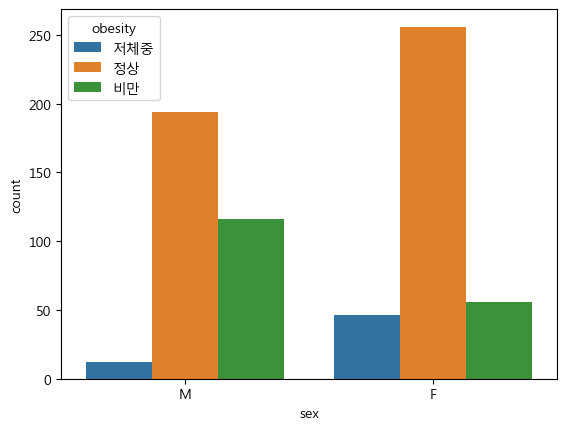

In [6]:
sns.countplot(data = data[data.age_group == '20대'], x='sex', hue = 'obesity')
plt.show()

### 카이 제곱 검정을 통해 성별로 저체중/정상체중/비만의 비율이 다른지 검증한다.

In [7]:
obesity_age20s = pd.crosstab(data[data.age_group == '20대'].sex, data[data.age_group == '20대'].obesity)
print(obesity_age20s)
stats.chi2_contingency(obesity_age20s)

obesity  저체중   정상   비만
sex                   
F         46  256   56
M         12  194  116


Chi2ContingencyResult(statistic=np.float64(47.63110585739196), pvalue=np.float64(4.5398006174993676e-11), dof=2, expected_freq=array([[ 30.535, 236.912,  90.553],
       [ 27.465, 213.088,  81.447]]))

In [8]:
# chi^2 = 47.63, p = 4.54*10^-11 으로 통계적으로 유의하게 다른 것을 확인.

## 20대 남녀 데이터만 따로 저장하여 처리

In [8]:
data_age20 = data[data.age_group == '20대']
data_age20

,ID,sex,age,height,weight,waist,BMI,Blood_glucose,obesity,age_group
12,A901024803,M,27,188.4,126.7,106.9,35.695611,90,비만,20대
13,A901024804,M,26,177.9,85.5,90.5,27.015575,96,비만,20대
68,A903022202,F,23,158.8,42.5,61.6,16.853416,86,저체중,20대
104,A904024203,M,29,188.2,67.0,71.6,18.916273,93,정상,20대
113,A904027203,F,26,169.9,58.5,66.5,20.266050,85,정상,20대
...,...,...,...,...,...,...,...,...,...,...
5931,R903029201,M,25,193.0,74.5,76.4,20.000537,95,정상,20대
5934,R903033301,M,25,174.7,73.8,89.2,24.180794,97,정상,20대
5935,R903034901,M,22,173.2,67.1,73.1,22.367979,94,정상,20대
5936,R903035101,M,22,175.5,63.0,74.1,20.454379,99,정상,20대


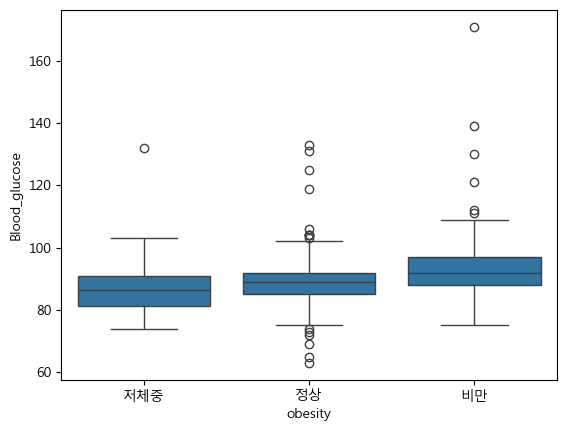

In [9]:
sns.boxplot(data = data_age20, y = 'Blood_glucose', x = 'obesity')
plt.show()

### 체중 분류에 따른 혈당(Blood_glucose) 차이가 나는지 ANOVA로 검증

In [10]:
# stats.f-oneway() 함수를 이용한 one-way ANOVA

Glucose1 = data_age20[data_age20.obesity == '저체중'].Blood_glucose
Glucose2 = data_age20[data_age20.obesity == '정상'].Blood_glucose
Glucose3 = data_age20[data_age20.obesity == '비만'].Blood_glucose

oneway_anova_result = stats.f_oneway(Glucose1, Glucose2, Glucose3)
oneway_anova_result

F_onewayResult(statistic=np.float64(21.84720724177906), pvalue=np.float64(6.389957551575535e-10))

In [11]:
# OLS (Ordinary Least Squares) 기반 모델 피팅을 이용한 ANOVA 

results = smf.ols('Blood_glucose ~ obesity', data = data_age20).fit()
sm.stats.anova_lm(results, typ=2)

,sum_sq,df,F,PR(>F)
obesity,2956.207059,2.0,21.847207,6.389958e-10
Residual,45803.387059,677.0,NaN,NaN


### 그룹 간에 유의한 차이가 있는 경우 사후 검정(post-hoc analysis) 시행

In [12]:
# 사후 검정 (Post-hoc analysis)
# ANOVA가 유의하게 나온 경우, 어느 그룹 쌍 간에 유의한 차이가 나는지 후속 분석.

from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(data_age20['Blood_glucose'], data_age20['obesity'], alpha=0.05)
posthoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
비만,저체중,-5.9463,0.0,-8.8799,-3.0127,True
비만,정상,-4.5567,0.0,-6.2887,-2.8247,True
저체중,정상,1.3896,0.4471,-1.3058,4.085,False


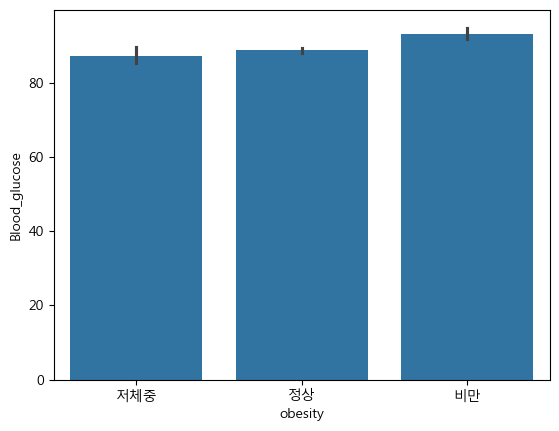

In [13]:
sns.barplot(data = data_age20, y = 'Blood_glucose', x = 'obesity')
plt.show()

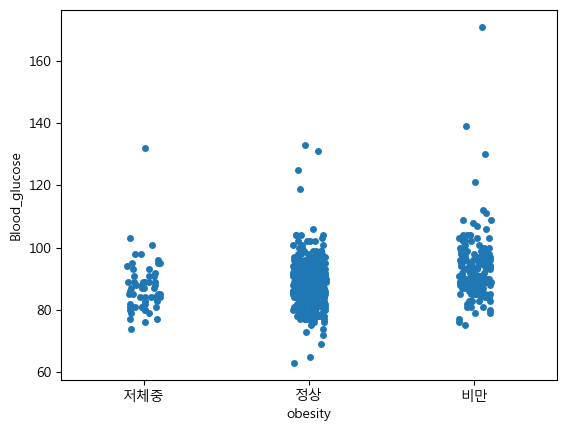

In [14]:
sns.stripplot(data = data_age20, y = 'Blood_glucose', x = 'obesity')
plt.show()

/Users/idowon/Library/Mobile Documents/com~apple~CloudDocs/Study/2025-school/2025-data-literacy/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 40.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/idowon/Library/Mobile Documents/com~apple~CloudDocs/Study/2025-school/2025-data-literacy/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 52.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/idowon/Library/Mobile Documents/com~apple~CloudDocs/Study/2025-school/2025-data-literacy/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


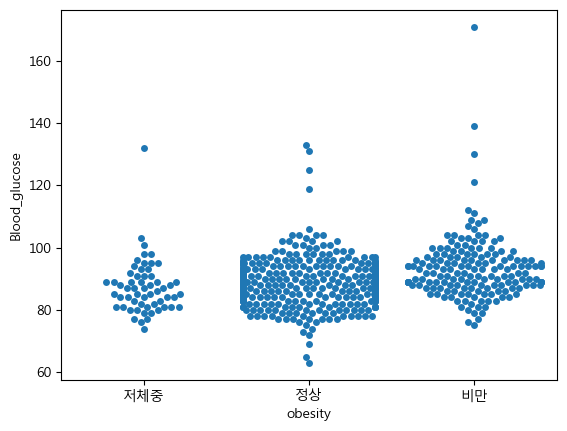

In [15]:
sns.swarmplot(data = data_age20, y = 'Blood_glucose', x = 'obesity')
plt.show()

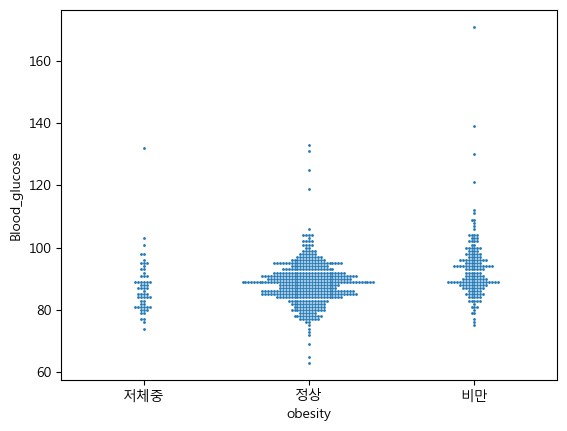

In [16]:
sns.swarmplot(data = data_age20, y = 'Blood_glucose', x = 'obesity', size = 2)
plt.show()

### 체중분류(obesity)에 따라 키(height)가 다른지 boxplot을 그리고 ANOVA로 분석해본다.

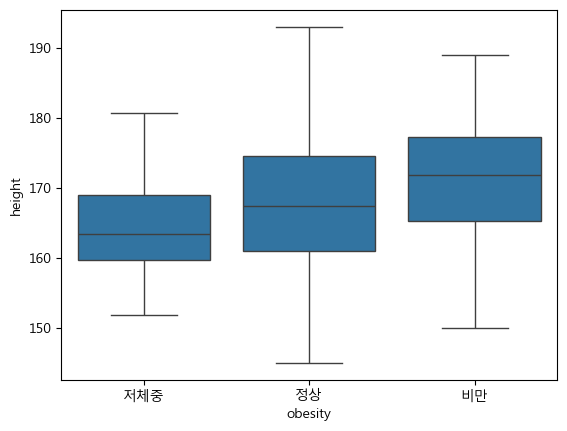

In [17]:
sns.boxplot(data=data_age20, x='obesity', y='height')
plt.show()

In [18]:
results = smf.ols('height ~ obesity', data = data_age20).fit()
sm.stats.anova_lm(results, typ=2)

,sum_sq,df,F,PR(>F)
obesity,2165.326067,2.0,15.186361,3.534370e-07
Residual,48264.549683,677.0,NaN,NaN


In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(data_age20['height'], data_age20['obesity'], alpha=0.05)
posthoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
비만,저체중,-6.2813,0.0,-9.2927,-3.2699,True
비만,정상,-3.3111,0.0,-5.089,-1.5332,True
저체중,정상,2.9702,0.0319,0.2033,5.7371,True


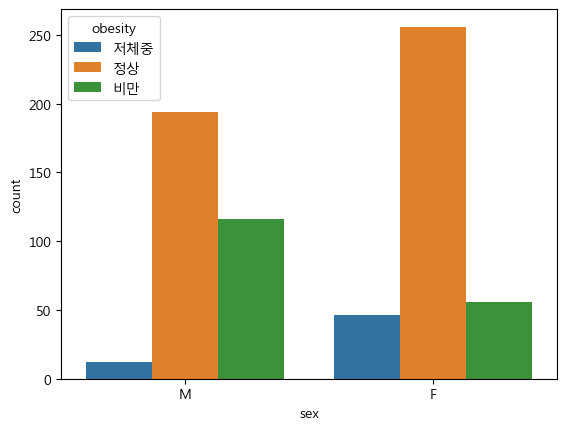

In [20]:
# 저체중 - 정상 - 비만 의 키 차이가 순수히 체중분류에 따른 것일까? 
# : 성별 분포를 비교해본다.
sns.countplot(data = data_age20, x='sex', hue = 'obesity')
plt.show()

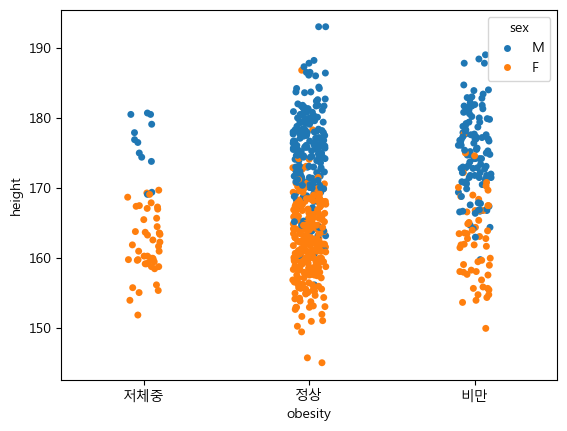

In [21]:
sns.stripplot(data = data_age20, x='obesity', y='height', hue='sex')
plt.show()

/Users/idowon/Library/Mobile Documents/com~apple~CloudDocs/Study/2025-school/2025-data-literacy/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


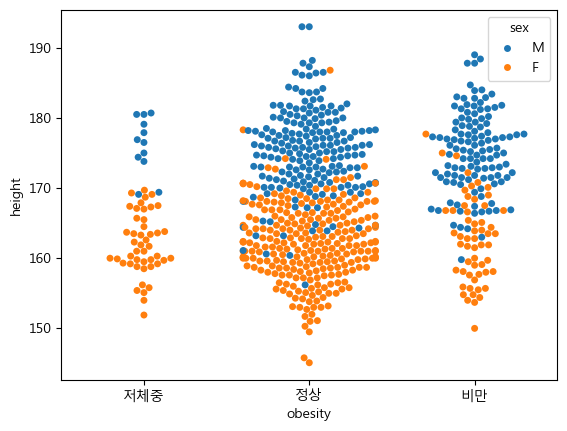

In [22]:
sns.swarmplot(data = data_age20, x='obesity', y='height', hue='sex')
plt.show()

### 성별로 나누어서 각각 따로 비교한 경우

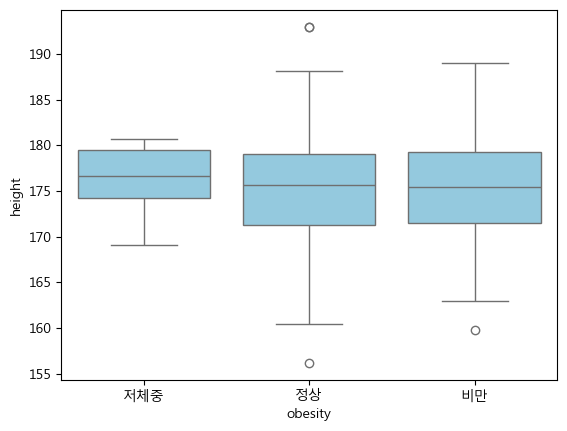

In [23]:
# 남성
sns.boxplot(data = data_age20.query("sex=='M'"), x='obesity', y='height', color = 'skyblue')
plt.show()

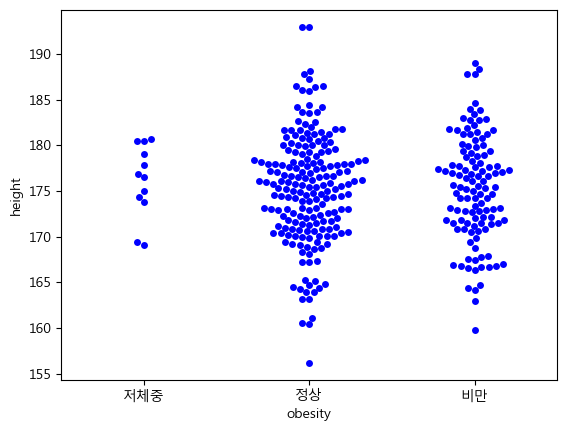

In [24]:
sns.swarmplot(data = data_age20.query("sex=='M'"), x='obesity', y='height', color = 'blue')
plt.show()

In [25]:
# ANOVA 분석 
# 남성
results = smf.ols('height ~ obesity', data = data_age20.query("sex=='M'")).fit()
sm.stats.anova_lm(results, typ=2)

,sum_sq,df,F,PR(>F)
obesity,9.107741,2.0,0.131272,0.877026
Residual,11066.195271,319.0,NaN,NaN


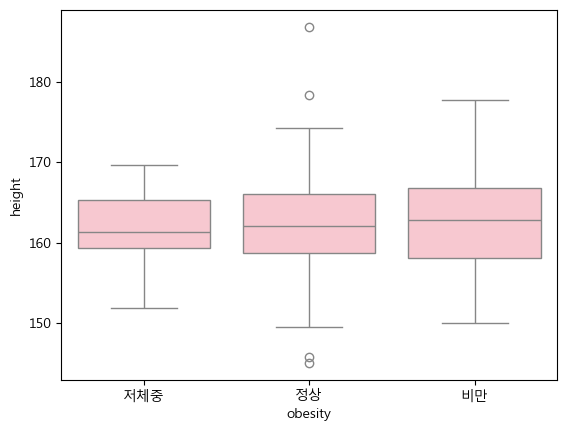

In [26]:
# 여성
sns.boxplot(data = data_age20.query("sex=='F'"), x='obesity', y='height', color = 'pink')
plt.show()

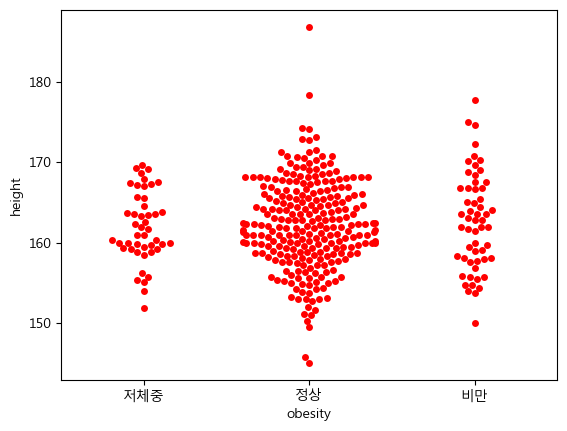

In [27]:
sns.swarmplot(data = data_age20.query("sex=='F'"), x='obesity', y='height', color = 'red')
plt.show()

In [28]:
# ANOVA 분석 
# 여성
results = smf.ols('height ~ obesity', data = data_age20.query("sex=='F'")).fit()
sm.stats.anova_lm(results, typ=2)

,sum_sq,df,F,PR(>F)
obesity,14.705088,2.0,0.244873,0.782936
Residual,10659.205638,355.0,NaN,NaN


---

## 비교할 그룹 간의 성별 비율 맞추기 (예시)
비만 vs. 정상체중 에서 혈당을 비교하고자 하는데, 비만 집단에서 남성의 비율이 더 높다.

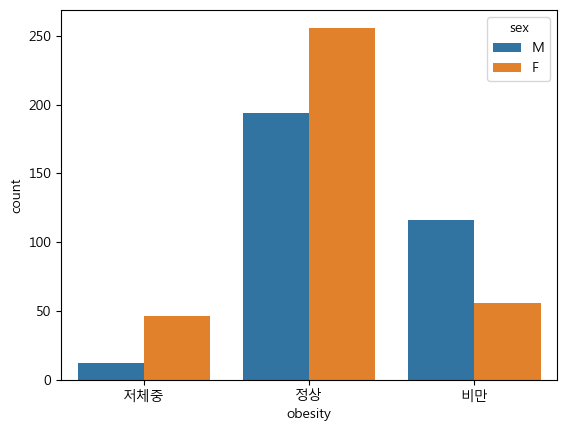

In [29]:
sns.countplot(data = data_age20, x='obesity', hue = 'sex')
plt.show()

In [30]:
data_obese = data_age20[data_age20.obesity == '비만']
data_obese.head()

,ID,sex,age,height,weight,waist,BMI,Blood_glucose,obesity,age_group
12,A901024803,M,27,188.4,126.7,106.9,35.695611,90,비만,20대
13,A901024804,M,26,177.9,85.5,90.5,27.015575,96,비만,20대
124,A905021101,M,27,184.7,109.2,106.4,32.010234,139,비만,20대
137,A905031002,M,28,181.2,144.2,129.7,43.918639,88,비만,20대
164,A906024401,M,26,182.9,98.5,99.8,29.444814,96,비만,20대


In [31]:
# 비만체중 집단 (전체) - 남녀 비율
N_male = sum(data_obese.sex=='M')
N_female = sum(data_obese.sex=='F')
print(N_male, N_female)
print(N_male/N_female)

116 56
2.0714285714285716


In [32]:
# 정상체중 집단 (전체) - 남녀 비율
data_normal = data_age20[data_age20.obesity == '정상']
print(sum(data_normal.sex=='M'), sum(data_normal.sex=='F'))
print(sum(data_normal.sex=='M')/sum(data_normal.sex=='F'))
# 남녀 성비가 다름.

194 256
0.7578125


In [33]:
# 비만 집단과 비교하기 위해서, 같은 남/녀 숫자로 정상체중 집단의 샘플을 추출해 통제군(control group) 생성.
data_control_M = data_normal[data_normal.sex=='M'].sample(n=N_male)
data_control_F = data_normal[data_normal.sex=='F'].sample(n=N_female)

In [34]:
data_control = pd.concat([data_control_M, data_control_F])
data_control

,ID,sex,age,height,weight,waist,BMI,Blood_glucose,obesity,age_group
2709,H901027704,M,24,170.1,68.1,80.3,23.536316,89,정상,20대
2886,H906022304,M,21,168.1,55.9,70.7,19.782282,96,정상,20대
1873,D902030603,M,22,170.2,71.4,81.4,24.647853,85,정상,20대
3877,H934032603,M,22,175.3,57.8,74.1,18.808926,80,정상,20대
1166,B902029803,M,24,179.4,69.1,75.8,21.470056,86,정상,20대
...,...,...,...,...,...,...,...,...,...,...
509,A917027203,F,23,163.1,52.4,63.6,19.698056,88,정상,20대
3622,H927027003,F,23,162.8,56.8,69.8,21.430857,84,정상,20대
5147,N904029402,F,29,166.8,57.9,72.0,20.810690,92,정상,20대
352,A912026903,F,22,161.4,61.5,76.7,23.608482,84,정상,20대


In [35]:
print(sum(data_obese.sex=='M'), sum(data_obese.sex=='F'))
print(sum(data_control.sex=='M'), sum(data_control.sex=='F'))

116 56
116 56


In [36]:
data_new = pd.concat([data_obese, data_control])
data_new

,ID,sex,age,height,weight,waist,BMI,Blood_glucose,obesity,age_group
12,A901024803,M,27,188.4,126.7,106.9,35.695611,90,비만,20대
13,A901024804,M,26,177.9,85.5,90.5,27.015575,96,비만,20대
124,A905021101,M,27,184.7,109.2,106.4,32.010234,139,비만,20대
137,A905031002,M,28,181.2,144.2,129.7,43.918639,88,비만,20대
164,A906024401,M,26,182.9,98.5,99.8,29.444814,96,비만,20대
...,...,...,...,...,...,...,...,...,...,...
509,A917027203,F,23,163.1,52.4,63.6,19.698056,88,정상,20대
3622,H927027003,F,23,162.8,56.8,69.8,21.430857,84,정상,20대
5147,N904029402,F,29,166.8,57.9,72.0,20.810690,92,정상,20대
352,A912026903,F,22,161.4,61.5,76.7,23.608482,84,정상,20대


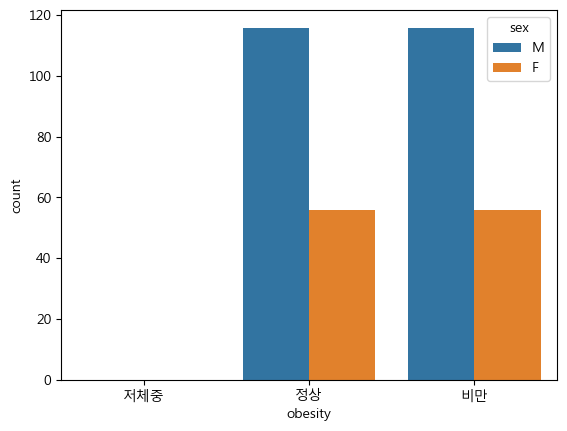

In [37]:
sns.countplot(data = data_new, x='obesity', hue = 'sex')
plt.show()

In [38]:
# 독립표본 t검정
[T_independent, p_independent] = stats.ttest_ind(data_new[data_new.sex=='M'].Blood_glucose, data_new[data_new.sex=='F'].Blood_glucose, equal_var = False)
print(T_independent, p_independent)

1.43785701423552 0.15204444861258903


/Users/idowon/Library/Mobile Documents/com~apple~CloudDocs/Study/2025-school/2025-data-literacy/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


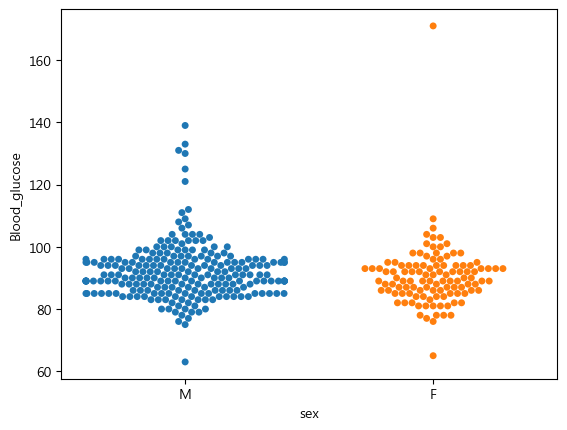

In [44]:
sns.swarmplot(data = data_new, x = 'sex', y = 'Blood_glucose', hue = 'sex')
plt.show()

In [40]:
[T_independent, p_independent] = stats.ttest_ind(data_new[data_new.obesity=='비만'].Blood_glucose, data_new[data_new.obesity=='정상'].Blood_glucose, equal_var = False)
print(T_independent, p_independent)

3.5194750685084704 0.0004939115732962055


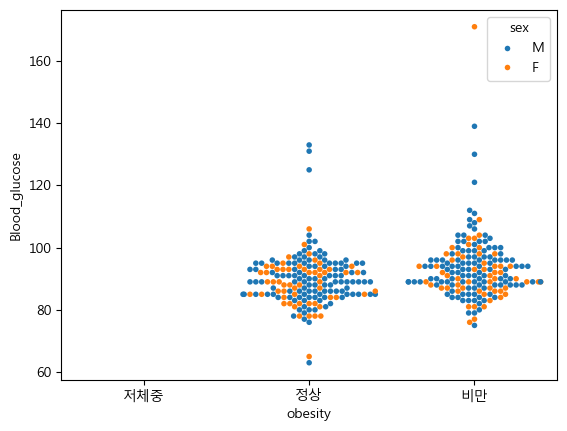

In [41]:
sns.swarmplot(data = data_new, x = 'obesity', y = 'Blood_glucose', hue = 'sex', size = 4)
plt.show()

---
## 환자군에 대응해 연령 및 성별 조건 맞춘 통제군 만들기
적은 수의 환자군을 먼저 지정하고, 그와 연령+성별 조건을 맞춘 통제군(control group)을 재추출.

In [42]:
# 전체 연령대 데이터 사용
data = data.dropna()
data.head()

,ID,sex,age,height,weight,waist,BMI,Blood_glucose,obesity,age_group
1,A901021301,M,78,167.7,76.4,98.3,27.166096,127,비만,70대
2,A901021302,F,75,157.7,53.2,80.7,21.391845,134,정상,70대
3,A901022601,F,43,151.0,53.5,79.7,23.463883,99,정상,40대
5,A901023304,F,71,157.2,53.2,78.4,21.528142,51,정상,70대
6,A901023501,M,44,180.0,85.6,96.1,26.419753,163,비만,40대


In [43]:
# 환자군 = 저체중 집단
data_lowW = data[data.obesity=='저체중']
print('N:', len(data_lowW))
pd.crosstab(data_lowW.sex, data_lowW.age_group)

N: 193


age_group,20대,30대,40대,50대,60대,70대
sex,,,,,,
F,46,43,28,19,9,3
M,12,8,9,4,4,8


In [45]:
pd.crosstab(data_lowW.sex, data_lowW.age_group)

age_group,20대,30대,40대,50대,60대,70대
sex,,,,,,
F,46,43,28,19,9,3
M,12,8,9,4,4,8


In [46]:
# 정상체중군 전체
data_normal = data[data.obesity=='정상']
print('N:', len(data_normal))
pd.crosstab(data_normal.sex, data_normal.age_group)

N: 3494


age_group,20대,30대,40대,50대,60대,70대
sex,,,,,,
F,256,328,445,464,357,246
M,194,191,230,285,290,208


In [47]:
## 환자군(저체중군)의 연령대+성별에 맞춘 통제군 추출하기

data_control = data_normal.head(0)

for sex_i in ['M', 'F']:
    for age_i in ['20대', '30대', '40대', '50대', '60대', '70대']:
        n_count = len(data_lowW[(data_lowW.sex==sex_i) & (data_lowW.age_group==age_i)])
        data_control = pd.concat([data_control, 
                                  data_normal[(data_normal.sex==sex_i) & (data_normal.age_group==age_i)].sample(n_count)])

print('N:', len(data_control))
pd.crosstab(data_control.sex, data_control.age_group)

N: 193


age_group,20대,30대,40대,50대,60대,70대
sex,,,,,,
F,46,43,28,19,9,3
M,12,8,9,4,4,8


In [48]:
data_control

,ID,sex,age,height,weight,waist,BMI,Blood_glucose,obesity,age_group
4738,L903024603,M,28,178.0,59.6,70.2,18.810756,87,정상,20대
2709,H901027704,M,24,170.1,68.1,80.3,23.536316,89,정상,20대
3933,H936032702,M,24,180.8,78.1,83.7,23.892092,93,정상,20대
5027,M907023403,M,20,170.1,61.5,73.7,21.255263,85,정상,20대
387,A913027101,M,26,169.1,64.4,76.6,22.521569,86,정상,20대
...,...,...,...,...,...,...,...,...,...,...
2005,D906031901,F,60,152.2,52.4,72.4,22.620489,103,정상,60대
730,A924032302,F,61,163.2,49.8,69.9,18.697736,94,정상,60대
1798,C909029202,F,75,155.3,55.3,83.3,22.928847,101,정상,70대
4992,M906022401,F,76,147.5,52.3,86.7,24.039069,100,정상,70대


In [49]:
## 환자군(저체중군)의 연령대+성별에 맞춘 통제군 추출하기
## 복원 추출: 통제군을 10배수로 추출

data_control = data_normal.head(0)

for sex_i in ['M', 'F']:
    for age_i in ['20대', '30대', '40대', '50대', '60대', '70대']:
        n_count = len(data_lowW[(data_lowW.sex == sex_i) & (data_lowW.age_group == age_i)])
        data_control = pd.concat([data_control, 
                                  data_normal[(data_normal.sex == sex_i) & (data_normal.age_group == age_i)].sample(n_count *10, replace=True)])
        # .sample()메소드의 replace=True 옵션: 복원추출 (원래 정상군 하위집단보다 더 많은 수의 샘플 추출 가능)
    
print('N:', len(data_control))
pd.crosstab(data_control.sex, data_control.age_group)

N: 1930


age_group,20대,30대,40대,50대,60대,70대
sex,,,,,,
F,460,430,280,190,90,30
M,120,80,90,40,40,80
